In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sbn

sbn.set() 

Tasks (SIGURD) : 

- (1) Fix the tests
- (3) Get uniformly distributed p-values
    - Compare LCG with System RNG.
    - Change approach to One simulation and split sample into smaller parts.
    - Google why p-values need to be uniform.

<h3> (1) Linear Congruential Generator </h3>

We define a linear congruentical generator algorithm for producing pseudo-random numbers as well as statistical tests and run tests for evaluating its performance.

In [108]:
def LCG(a = 5, c = 1, M = 16, x0 = 3, n = 10000):
    """ Linear congruential generator for generating psuedo random numbers"""
    x = np.zeros(n)
    x[0] = x0

    for i in range(1, n):
        x[i] = int((a * x[i - 1] + c ) % M)

    return x.astype(int)

def test_chi_square(U):
    """ Compute the p-value of the null-hypothesis that the pseudo-random
        numbers come from a uniform distribution. """
    n = U.shape[0]
    
    k = int(n / 500)

    n_observed = np.histogram(U, bins=k, range=(0,1))[0]
    
    # Compute test statistics
    n_expected = n / k # Choose n_expected >= 5
    Z = ((n_observed - n_expected) ** 2 / n_expected).sum() # test statistic
    
    p = 1 - stats.chi2.cdf(Z, df = k - 1)

    return Z, p # (test statistic, p-value)

def test_ks(U):
    """ Kolmogorov-Smirnov test """
    n = U.shape[0]

    Fxn = U.copy()
    Fxn.sort()

    # Fxn = ECDF(U).x[1:] # Empirical distribution
    
    Fx = np.linspace(0, 1, n) # Hypothesised uniform distribution
    
    Dn = np.abs(Fxn - Fx).max() # Test statistic
    Dn_adjusted = (np.sqrt(n) + .12 + .11 / np.sqrt(n)) * Dn

    # p_value
    p = 1 - stats.kstwobign.cdf(Dn_adjusted)

    # p = stats.kstwo.sf(Dn_adjusted, 1)

    return Dn_adjusted, p

def test_above_below(U):
    n = U.shape[0]

    Ra = 0
    Rb = 0

    mid = np.median(U)

    n1 = U[U > mid].shape[0]
    n2 = U[U < mid].shape[0]

    mean_ = 2 * n1 * n2 / (n1 +  n2)
    var_ = (2 * n1 * n2) * (2 * n1 * n2 - n1 - n1) / ((n1 + n2) ** 2 * (n1 + n2 - 1))

    diffs = U - mid

    for i in range(0, n):
        # handle first value separately
        if i == 0:
            cur = np.sign(diffs[i])
            if cur > 0:
                Ra += 1
            elif cur < 0:
                Rb += 1 

            continue

        cur = np.sign(diffs[i])
        prev = np.sign(diffs[i - 1])
        if cur != prev:
            if cur > 0:
                Ra += 1
            elif cur < 0:
                Rb += 1 

    Z = Ra + Rb # Test statistic
    p = 2*(1 - stats.norm.cdf(np.abs(Z-mean_), loc = 0, scale = np.sqrt(var_))) # p-value

    return Z, p

def test_up_down_knuth(U):
    """ Run test by Knuth """
    n = U.shape[0]
    R = np.zeros(6) # runs

    counter = 1

    for i in range(1, n):
        if U[i] >= U[i-1]: # Should it be GOQ?
            counter += 1
        else:
            if counter > 5:
                R[5] += 1
            else:
                R[counter - 1] += 1
            counter = 1
    
    A = np.array([[4529.4, 9044.9, 13568, 18091, 22615, 27892],
                  [9044.9, 18097, 27139, 36187, 45234, 55789],
                  [13568, 27139, 40721, 54281, 67852, 83685],
                  [18091, 36187, 54281, 72414, 90470, 111580],
                  [22615, 45234, 67852, 90470, 113262, 139476],
                  [27892, 55789, 83685, 111580, 139476, 172860]])
    
    B = np.atleast_2d([1/6, 5/24, 11/120, 19/720, 29/5040, 1/840]).T

    R = np.atleast_2d(R).T

    Z = (1/(n - 6) * (R - n*B).T @ A @ (R - n * B))[0, 0]

    p = 1 - stats.chi2.cdf(Z, df = 6)

    return Z, p

def test_up_down_rubenstein(U):
    """ Run test described in Rubenstein 1981 """
    n = U.shape[0]
    
    runs = []

    cur_run = '<' if U[0] <= U[1] else '>'

    counter = 1

    for i in range(1, n - 1):
        if cur_run == '<':
            if U[i] <= U[i + 1]:
                counter += 1
            else:
                cur_run = '>'
                runs.append(counter)
                counter = 1
        else:
            if U[i] >= U[i + 1]:
                counter += 1
            else:
                cur_run = '<'
                runs.append(counter)
                counter = 1

    runs.append(counter)

    X = len(runs)

    Z = (X - (2 *n - 1) / 3) / np.sqrt((16* n - 29) / 90)

    p = 2 * (1 - stats.norm.cdf(np.abs(Z)))

    return Z, p

def test_correlation(U, h = 1):
    n = U.shape[0]

    sum_ = 0

    for i in range(n - h):
        sum_ += U[i] * U[i + h]

    ch = 1 / (n - h) * sum_

    Z = ch # test statistic

    p = 2 * (1 - stats.norm.cdf(np.abs(Z), loc = 0.25, scale = 7 / (144 * n)))

    return Z, p

def conduct_tests(U):
    Z, p = test_chi_square(U)
    print(f'Chi-square test: test-statistic: {Z}, p-value: {p}')
    Z, p = test_ks(U)
    print(f'Kolmogorov-Smirnov test: test-statistic: {Z}, p-value: {p}')
    Z, p = test_above_below(U)
    print(f'Run test I (Above-Below): test-statistic: {Z}, p-value: {p}')
    Z, p = test_up_down_knuth(U)
    print(f'Run test II (Up-Down Knuth): test-statistic: {Z}, p-value: {p}')
    Z, p = test_up_down_rubenstein(U)
    print(f'Run test III (Up-Down Rubenstein): test-statistic: {Z}, p-value: {p}')
    Z, p = test_correlation(U, h = 2)
    print(f'Correlation test: test-statistic: {Z}, p-value: {p}')

<h3>(1a) Generate 10 000 pseudo-random numbers</h3>

A sample of 10000 pseudo-random numbers are generated using the linear congruential generator using the same parameter values as in the slideshow.

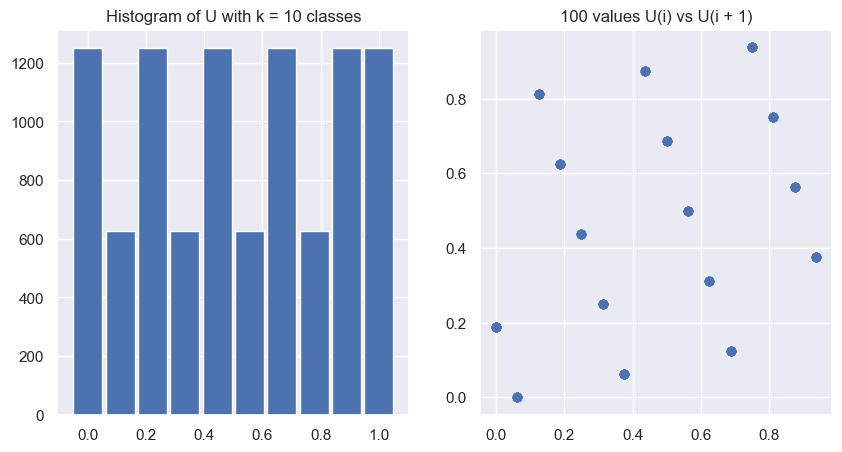

In [107]:
# Parameter values
n = 10000
x0 = 3
M = 16
a = 5
c = 1

X = LCG(a = a, c = c, M = M, x0 = x0, n = n)
U = X / M

k = 10 # Number of classes

heights = np.histogram(U, bins = k)[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(np.linspace(0, 1, k), height = heights, width = .1, )
ax[0].set_title(f'Histogram of U with k = {k} classes')
ax[1].scatter(U[:100][1:], U[:100][:-1])
ax[1].set_title(f'100 values U(i) vs U(i + 1)')
plt.show()

We see from the plots above that the sample of 10000 pseudo random numbers on the surface does not look likely to be uniform and independently distributed. There are high and low peaks in the histogram, and the scatter plot show that there seem to be a pattern between the samples, indicating that the values are highly correlated. Statistical tests can help verify these observations.

<h3>(b) Evaluate quality of generators </h3>

In [80]:
conduct_tests(U)

Chi-square test: test-statistic: 2500.0, p-value: 0.0
Kolmogorov-Smirnov test: test-statistic: 6.25756875, p-value: 0.0
Run test I (Above-Below): test-statistic: 3750, p-value: 0.0
Run test II (Up-Down Knuth): test-statistic: 1121.7927884219291, p-value: 0.0
Run test III (Up-Down Rubenstein): test-statistic: -9.875106965999812, p-value: 0.0
Correlation test: test-statistic: 0.2168343825015003, p-value: 2.0


We see from these result that using Chi-square, Kolmogorov-Smirnov and run tests we are able to reject the null hypothesis that the pseudo-random numbers are uniformly distributed using significance level $\alpha = 0.05$, confirming the suspicion from the visual tests of histogram and correlations.

<h3>(c) Repeat experiment with different parameter values of LCG</h3>

We have already reported bad values of $(a, c, M, x_0) = (5, 1, 16, 3)$ in the previous task. To create a LCG that work well we have experimented with different parameter values and searched the internet for inspiration. We have settled on the following values:

$M = 2^{48} $,
$a = 25214903917$,
$c = 11$,
$x_0 = 3$

We will generate a sample of 10000 pseudo-random numbers using these values and run the same tests as in the previous task

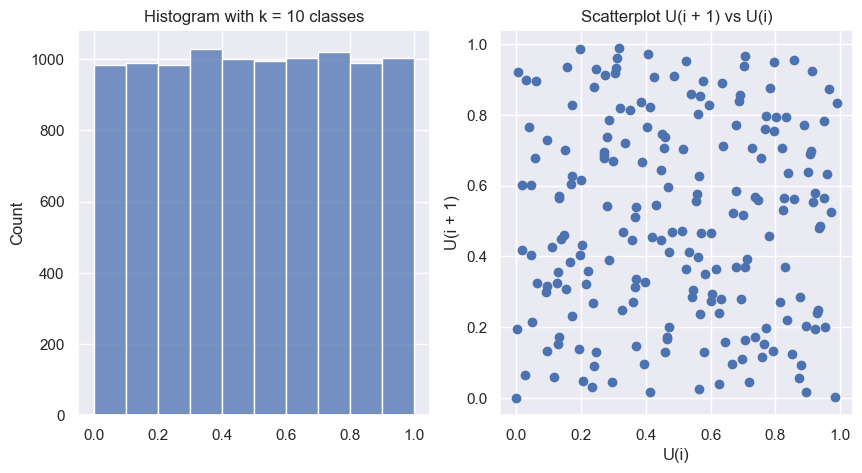

In [87]:
# a) Generate 10 000 numbers and plot them in histogram
n = 10000
k = 10
M = 2 ** 48
a = 25214903917
c = 11
x0 = 3

# Generating and plotting
nums = LCG(a, c, M, x0, n)
U = nums / M
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sbn.histplot(U, bins=k, ax=ax[0])
ax[0].set_title(f"Histogram with k = {k} classes")
ax[1].scatter(U[:200][:-1], U[:200][1:])
ax[1].set_ylabel("U(i + 1)")
ax[1].set_xlabel("U(i)")
ax[1].set_title(f"Scatterplot U(i + 1) vs U(i)")

plt.show()


In [88]:
conduct_tests(U)

Chi-square test: test-statistic: 9.516, p-value: 0.9638928369705171
Kolmogorov-Smirnov test: test-statistic: 0.5817708427811435, p-value: 0.8874606871104923
Run test I (Above-Below): test-statistic: 5023, p-value: 0.6454997087450891
Run test II (Up-Down Knuth): test-statistic: 0.9072088201269317, p-value: 0.9888865245268389
Run test III (Up-Down Rubenstein): test-statistic: 0.6562320882129656, p-value: 0.5116748056549036
Correlation test: test-statistic: 0.2509467131473625, p-value: 0.0


For these parameters of the LCG we get from the plots that they are seemingly uniformly distributed. The vertical bars of the histogram are closely alligned but not exactly the same, indicating that there is some (pseudo) random variation in the frequency of the sample. The plot to the right show no real pattern between one sample and the next in the sequence, meaning that they are not correlated with each other. 

As for the statistical tests, none return a p-value larger than $\alpha = 0.05$, meaning that we accept the null-hypothesis of the sample coming from a uniform distribution.

<h3>(2) Apply a system RNG and perform the same tests</h3>

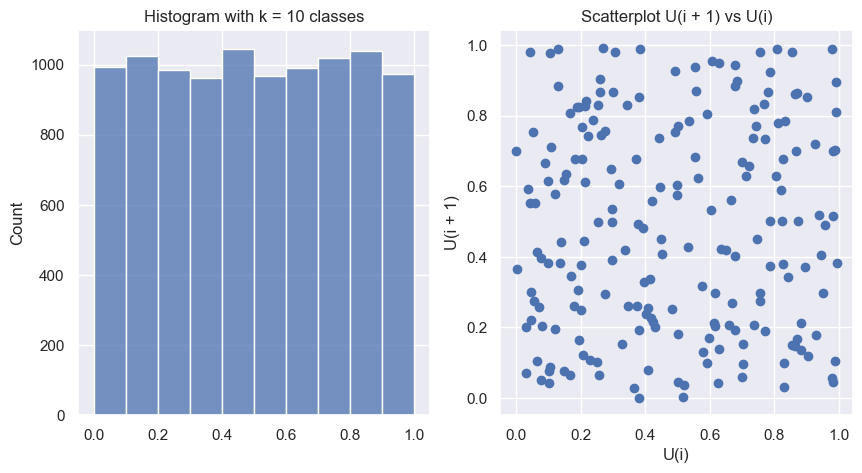

In [89]:
U = np.random.uniform(0, 1, size = 10000)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sbn.histplot(U, bins=k, ax=ax[0])
ax[0].set_title(f"Histogram with k = {k} classes")
ax[1].scatter(U[:200][:-1], U[:200][1:])
ax[1].set_ylabel("U(i + 1)")
ax[1].set_xlabel("U(i)")
ax[1].set_title(f"Scatterplot U(i + 1) vs U(i)")

plt.show()

In [90]:
conduct_tests(U)

Chi-square test: test-statistic: 12.74, p-value: 0.8516110254637647
Kolmogorov-Smirnov test: test-statistic: 0.4692173841924895, p-value: 0.980315045437928
Run test I (Above-Below): test-statistic: 4929, p-value: 0.15558700837104
Run test II (Up-Down Knuth): test-statistic: 2.5038750738478024, p-value: 0.8680337311315198
Run test III (Up-Down Rubenstein): test-statistic: 1.5101244439599477, p-value: 0.13101167330598562
Correlation test: test-statistic: 0.25123105400113305, p-value: 0.0


We get the similar results in the previous task. Here, however the bars of the histogram are less alligned.

<h3>(3) Multiple sample test</h3>

The problem with measuring the performance of our RNG using only a single sample is that we may come to the wrong conclusions due to random variations in the sample generation. It would be better if we performed more experiments and averaged the results, to get a better idea on how the generator performs consistently. For this purpose we choose to sample ten million numbers with our LCG and peform the chisquare test on intervals of size 10000. Here we would expect the p-values to be uniformly distributed. 

We perform the experiments using paramter values from task (1c) and compare with the same experiment using a built-in RNG.

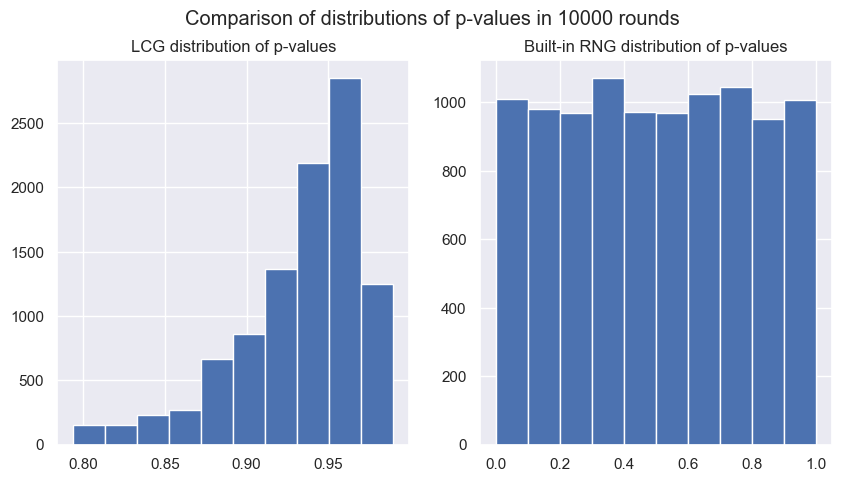

In [106]:
n_sample = int(1e8)
n = 10000
U_lcg = LCG(a = a, c = c, M = M, x0 = x0, n = n_sample) / M
U_system = np.random.uniform(0, 1, size = n_sample)

rounds = int(n_sample / n)

p_vals_lcg = np.zeros(rounds)
p_vals_system = np.zeros(rounds)

for r in range(rounds):
    u = U_lcg[r*n:(r+1)*n]
    _, p = test_chi_square(u)
    p_vals_lcg[r] = p

    u = U_system[r*n:(r+1)*n]
    _, p = test_chi_square(u)
    p_vals_system[r] = p

n_bins = 10

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(p_vals_lcg, bins = n_bins)
ax[0].set_title('LCG distribution of p-values')
ax[1].hist(p_vals_system, bins = n_bins)
ax[1].set_title('Built-in RNG distribution of p-values')
fig.suptitle(f'Comparison of distributions of p-values in {rounds} rounds')

plt.show()

We see from these results that the p-values of the built-in random number generator are uniformly distributed as would be expected. The p-values of our own implementation using LCG however is not, with values in the range 0.8 - 1.0 only. This indicates that our implementation is not 'random' enough, as we would expect lower p-values for some runs as well.